# Fitting more efficiently star profiles with a PSF model using DAOPHOT NSTAR-MCMC from Python

Second tutorial of the tutorial series showing how to use NSTAR-MCMC from Python with a shared Fortran library.

                  Version 1.0 - 11 April 2022
                         Clément Ranc

For a general introduction, please have a look to the [README](https://github.com/clementranc/nstarwrap#readme). Please follow the [Tuto 1](https://github.com/clementranc/nstarwrap/blob/main/Tutorials/Tutorial_1/Notebook.ipynb) before starting this tutorial.

In [12]:
import emcee
from IPython.display import Image
import moana
import nstarwrap.daotools as daotools
import numpy as np
import os
import pandas as pd
import time

## Real world example: a 2-star fit (continuation)

**Goal:** In this section, we show how to perform a 2-star fit using an MCMC with a rescaling.

### MCMC with rescaled error bars

A clean directory includes:
- An image, here `image.fits`
- A PSF model produced by DAOPHOT, here `image.psf`
- A list of stars of interest produced by DAOPHOT Group command, here `image.grp`

We start by defining some basic variables, most of them are self explanatory.

In [2]:
# Filenames
image_file_name = 'image.fits'
psf_model_file_name = 'image.psf'
group_file_name = 'image.grp'

# Needed parameters from the daophot.opt file or standard values.
watch = 0.0
fitrad = 9.8
e1 = 0.75
e2 = 5.0

# Fitting box limits
box_xmin, box_xmax, box_ymin, box_ymax = 1100, 1128, 1171, 1197

# Initial position in the parameter space.
# (x, y) position of star 1 (the brightest) and star 2 (the faintest),
# Flux ratio between star 2 and star 1
x1fg, y1fg = 1112.536, 1183.238
x2fg, y2fg = 1112.368, 1189.931
flux_ratio12_fg = 0.584269

# Rescaling factor derived from the Tuto 1
err_factor = 0.236123

# Random generator
SEED = 42  # Random seed for reproductibility and debugging
rng = np.random.default_rng(SEED)  # Initialize the random generator

Now, we need to import the Fortran DAOPHOT shared library and run the `ATTACH command`. MOAna is doing it for you. Unlike in Tuto 1, we use the option `pickle=True` here, to create a local binary file of the FITS file. This file can be deleted at the end of your analysis (it is a temporary file, and can only be used in a similar OS, or on the same computer). It is highly recommended to use this option.

Moreover, we add an error rescaling factor derived from Tuto 1.

In [3]:
# Import the shared library
nstar_wrapper = daotools.NstarPythonWrapper(
    image=image_file_name,
    psf=psf_model_file_name,
    group=group_file_name,
    watch_daophot=watch, 
    fitrad_daophot=fitrad, 
    e1_daophot=e1,
    e2_daophot=e2,
    fitting_box=[box_xmin, box_xmax, box_ymin, box_ymax],
    err_factor=err_factor,
    pickle=True)
ncol, nrow = nstar_wrapper.attach()
print(f'ncol = {ncol.value}, nrow={nrow.value}')

/Users/Ranc/Travail/Moi/Recherche/Codes/DAOPHOT/daophot4-mcmc/pywrapper.so
ncol = 2290, nrow=2290


Notice the file `image.fits.pkl` created. From now on, to optimize the code, we will use this file instead of the image FITS file.

In [4]:
# Replace the image filename to use the new create file
image_file_name = 'image.fits.pkl'

# Re-import the shared library to actually use the 'image.fits.pkl'
nstar_wrapper = daotools.NstarPythonWrapper(
    image=image_file_name,
    psf=psf_model_file_name,
    group=group_file_name,
    watch_daophot=watch, 
    fitrad_daophot=fitrad, 
    e1_daophot=e1,
    e2_daophot=e2,
    fitting_box=[box_xmin, box_xmax, box_ymin, box_ymax],
    err_factor=err_factor,
    pickle=True)

# Run again the ATTACH command that will now load 'image.fits.pkl' instead
# of the FITS file.
ncol, nrow = nstar_wrapper.attach()
print(f'ncol = {ncol.value}, nrow={nrow.value}')

/Users/Ranc/Travail/Moi/Recherche/Codes/DAOPHOT/daophot4-mcmc/pywrapper.so
ncol = 2290, nrow=2290


Notice that the result so far is the same as when using the FITS file.

### MCMC, prior and posterior distributions

The MCMC performed below follows the same general approach as NSTAR-MCMC developed by Sean Terry, i.e., the badness-of-fit is computed exactly in the same way, and the fit is performed inside a fitting box. However, the constraints on the parameters are managed in a different way, adopting a Bayesian approch, i.e., using a prior distribution.

In [5]:
# Define the log-prior
def log_prior(x):
    if (box_xmin < x[0] < box_xmax)\
        and (box_xmin < x[2] < box_xmax)\
        and (box_ymin < x[1] < box_ymax)\
        and (box_ymin < x[3] < box_ymax)\
        and (0 < x[4]):
        return 0.0
    return -np.inf

# Define the log-probability function
def log_probability(x):
    x1, y1, x2, y2, fratio = x
    
    # Trick: we want star 1 to always be the brightest.
    # TODO: remove this trick.
    theta = x
    if fratio > 1:
        fratio = 1.0 / fratio
        x1, x2, y1, y2 = x[2], x[0], x[3], x[1]
        theta = [x[2], x[0], x[3], x[1], fratio]
        
    # Evaluate the log(prior)
    lp = log_prior(theta)
    if np.isinf(lp):
        return lp, 0.0
    
    # Run NSTAR-MCMC to compute the chi-square and the total flux in the fitting box
    chisq, total_flux = nstar_wrapper.nstar_goodness_of_fit(theta)
    
    return -0.5 * chisq + lp, total_flux

We initialize the MCMC and run it. This cell is explained in Tuto 1.

In [6]:
ndim = 5
nwalkers = 10
max_n = 2000  # Length of the MCMC chains

star1 = x1fg + 1j * y1fg
star2 = x2fg + 1j * y2fg

mu, sigma = 0, 1
inside_box = [True]
i = 0
while(any(inside_box)):
    p1 = star1 + rng.normal(mu, sigma, nwalkers) * np.exp(1j * rng.uniform(0, 2*np.pi, nwalkers))
    p2 = star2 + rng.normal(mu, sigma, nwalkers) * np.exp(1j * rng.uniform(0, 2*np.pi, nwalkers))
    p0 = np.array([p1.real, p1.imag, p2.real, p2.imag, 
                   flux_ratio12_fg + rng.normal(0, 0.3, nwalkers)]).T
    inside_box = np.array([log_prior(a) for a in p0]) < 0
    i = i+1
    if i > 10:
        print('Please change the box size of adapt the random choices to your box size.')
        break
p0[0] = np.array([x1fg, y1fg, x2fg, y2fg, flux_ratio12_fg])

backend = emcee.backends.HDFBackend("my_mcmc.h5")
backend.reset(nwalkers, ndim)
nstar_params_name_light = ["z0"]
dtype = [(a, np.float64) for a in nstar_params_name_light]

# Initialization of the sampler with all the previous parameters
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
    blobs_dtype=dtype, backend=backend)

# Start the MCMC run
start = time.time()
sampler.run_mcmc(p0, max_n, progress=True);
end = time.time()
run_time = end - start

print("Run took {0:.1f} minute(s)".format(run_time/60))


100%|██████████| 2000/2000 [01:18<00:00, 25.41it/s]

Run took 1.3 minute(s)


Let's plot the correlations and the best fit model.

In [7]:
# Print basic information about the MCMC run
burnin = 0
print(f'Autocorrelations:')
print(f'   [Shape: {sampler.get_chain(discard=burnin, flat=False).shape}]')
print(f'   {sampler.get_autocorr_time(quiet=True)}')
samples = sampler.get_chain(discard=burnin, flat=True)
log_prob_samples = sampler.get_log_prob(discard=burnin, flat=True)
out = sampler.get_blobs(discard=burnin, flat=True)
print(f'Zeropoint Mag: {nstar_wrapper.zpmag.value:.4f}')

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau: [32.0757027  38.74505729 49.10524411 67.7467544  24.42751389]


Autocorrelations:
   [Shape: (2000, 10, 5)]
   [32.0757027  38.74505729 49.10524411 67.7467544  24.42751389]
Zeropoint Mag: 13.5920


The MCMC seems too short. Let's continue it from its last position. We can do that directly since the `sampler` is in memory. However, to show how to do it in the most general case, we are going to load the MCMC samples again and continue the MCMC.

In [8]:
# Initialization of the sampler from a previous run
backend = emcee.backends.HDFBackend("my_mcmc.h5")
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                blobs_dtype=dtype, backend=backend)

# Re-start the MCMC run from its last state
max_n = 1000
start = time.time()
sampler.run_mcmc(None, max_n, progress=True);
end = time.time()
run_time = end - start

100%|██████████| 1000/1000 [00:39<00:00, 25.44it/s]


,x1,y1,x2,y2,flux_ratio,FTOTAL,chi2,dchi2
15535,1112.531599,1183.223449,1112.358295,1189.984527,0.856841,0.860409,776.914256,0.0


Each sub-plot must be 4.863in x 4.863in to have a figure of 6.614in. Okay! I'm using it!


<Figure size 432x288 with 0 Axes>

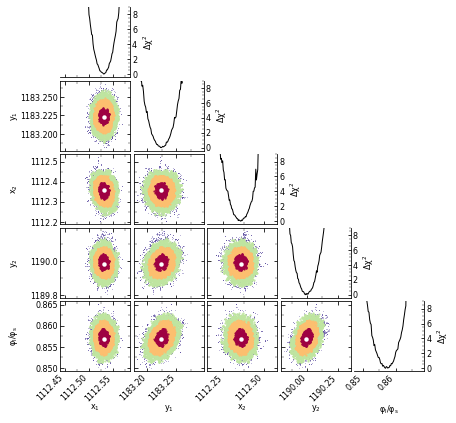

In [9]:
# Compute missing quantities and miscellaneous things explained in Tuto 1
colnames = np.array(['x1', 'y1', 'x2', 'y2', 'flux_ratio'])
mcmc_out = pd.DataFrame(samples, columns=colnames)
mcmc_out['FTOTAL'] = out['z0']

# Don't forget to take into account when flux ratio > 1.0
# TODO: remove that!
mask = mcmc_out['flux_ratio'] > 1
mcmc_out.loc[mask, 'flux_ratio'] = 1 / mcmc_out.loc[mask, 'flux_ratio']
x1 = mcmc_out.loc[mask, 'x2']
y1 = mcmc_out.loc[mask, 'y2']
x2 = mcmc_out.loc[mask, 'x1']
y2 = mcmc_out.loc[mask, 'y1']
mcmc_out.loc[mask, 'x1'] = x1
mcmc_out.loc[mask, 'y1'] = y1
mcmc_out.loc[mask, 'x2'] = x2
mcmc_out.loc[mask, 'y2'] = y2
mcmc_out['chi2'] = - 2.0 * log_prob_samples
mcmc_out['dchi2'] = mcmc_out['chi2'] - np.min(mcmc_out['chi2'])
display(mcmc_out[mcmc_out['chi2']==np.min(mcmc_out['chi2'])])

# Plot scatter plot
labels = ['x1', 'y1', 'x2', 'y2', 'flux_ratio']

label_display = dict({'x1': r'x_1', 'x2': r'x_2', 'y1': r'y_1', 'y2': r'y_2',   
    'flux_ratio': r'\varphi_l/\varphi_s'})

mask = mcmc_out['dchi2'] < 100

posterior = moana.SampledPosterior(mcmc_out[mask], labels=labels)
fig, ax = posterior.corner_plot(credible_intervals=False, diagonal='chi2', 
    rotation=45, show_samples=True, labels=label_display);

bf = mcmc_out[mcmc_out['chi2']==np.min(mcmc_out['chi2'])][labels].values[0]
[ax[j][i].scatter(bf[i], bf[j], s=20, lw=0, marker='o', c='w') 
 for i in range(len(labels)) for j in range(len(labels)) if i<j]

# Save the figure
fig.savefig('correlation.png', bbox_inches='tight', dpi=72, pad_inches=0.1)

The result should be similar to this plot:

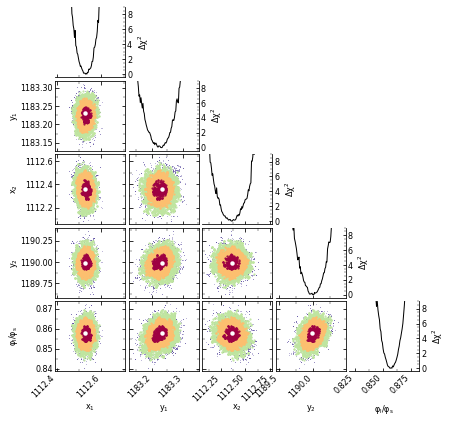

In [14]:
Image(filename='../Tutorial_1/illustrations/Correlation.png', width=600)

In [10]:
print(f'Degrees of freedom: {nstar_wrapper.dof:d}')
print(f"Best chi-square: {np.min(mcmc_out['chi2']):.4f}")
print(f"Best chi-square/d.o.f = {np.min(mcmc_out['chi2'])/nstar_wrapper.dof:.6f}")

Degrees of freedom: 777
Best chi-square: 776.9143
Best chi-square/d.o.f = 0.999890


## Multiprocessing and real world scripts

In practice, I do not recommend to run the MCMC in a Jupyter Notebook. A python script provides more options, especially the use of multiprocessing (it is possible in Jupyter Notebooks but I will not do that here). The next tutorial include a script I wrote in python that enable to fit using all the available CPUs (or a specified number of them). It is this script I strongly recommend to use and adapt to your study. I will still use a Jupyter Notebook to analyze the output files. Please move now to the Tuto 3.

## Important information for advanced usage

This section is a work in progress. TODO:

- [ ] Default vs. given fitting box borders.
- [ ] Refer to Sean's flux ratio calculations to derive a first guess of the flux ratio.